# Brownian Bridge

Método de interpolación entre dos puntos mediante un proceso estocástico, manteniendo las propiedades de un movimiento browniano (o proceso de Wiener).

$X(T)=X(0)+\dfrac{t}{T}\left( X(T)-X(0) \right)+W(t)-\dfrac{t}{T}W(T)$

Donde:  
- $W(t)$ = Proceso de Wiener
- $t$ = Tiempo actual (inicial)
- $T$ = Tiempo final
- $X(0)$ = Valor inicial
- $X(T)$ = Valor final

In [22]:
import numpy as np
import os
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pandas as pd
from scipy.special import mathieu_cem
from scipy.interpolate import PchipInterpolator

In [3]:
def graficar_angulos_en_circulo(angulos):
    # Crear una figura y un set de ejes
    fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
    
    # Dibujar el círculo unitario
    circulo = plt.Circle((0, 0), 1, color='blue', fill=False, linestyle='--')
    ax.add_artist(circulo)

    # Coordenadas del círculo unitario
    x_circulo = np.cos(np.linspace(0, 2 * np.pi, 100))
    y_circulo = np.sin(np.linspace(0, 2 * np.pi, 100))
    ax.plot(x_circulo, y_circulo, 'b--')  # Línea del círculo

    # Graficar los puntos correspondientes a los ángulos en el círculo unitario
    for angulo in angulos:
        x = np.cos(angulo)
        y = np.sin(angulo)
        ax.plot([0, x], [0, y], color='gray', linestyle='--')  # Línea desde el origen
        ax.plot(x, y, 'ro')  # Punto en el círculo

    # Ajustes del gráfico
    ax.set_xlim([-1.2, 1.2])
    ax.set_ylim([-1.2, 1.2])
    ax.set_xlabel('Eje X')
    ax.set_ylabel('Eje Y')
    ax.set_title('Ángulos en el círculo unitario')
    
    # Dibujar los ejes
    ax.axhline(0, color='black',linewidth=0.5)
    ax.axvline(0, color='black',linewidth=0.5)

    # Mantener proporciones iguales
    ax.set_aspect('equal')
    plt.grid(True)
    plt.show()


In [23]:
def brownian_bridge(t0, tT, x0, xT, n_steps=100):
    t = np.linspace(t0, tT, n_steps)
    #Generar movimiento browniano con media cero
    W = np.random.normal(0, np.sqrt(t[1] - t[0]), size=n_steps-1)
    W = np.insert(np.cumsum(W), 0, 0)  # Inserta W(0) = 0 y suma acumulativa
    # Interpolación del Brownian Bridge
    X = x0 + (t - t0) / (tT - t0) * (xT - x0) + W - (t - t0) / (tT - t0) * W[-1]
    return t, X

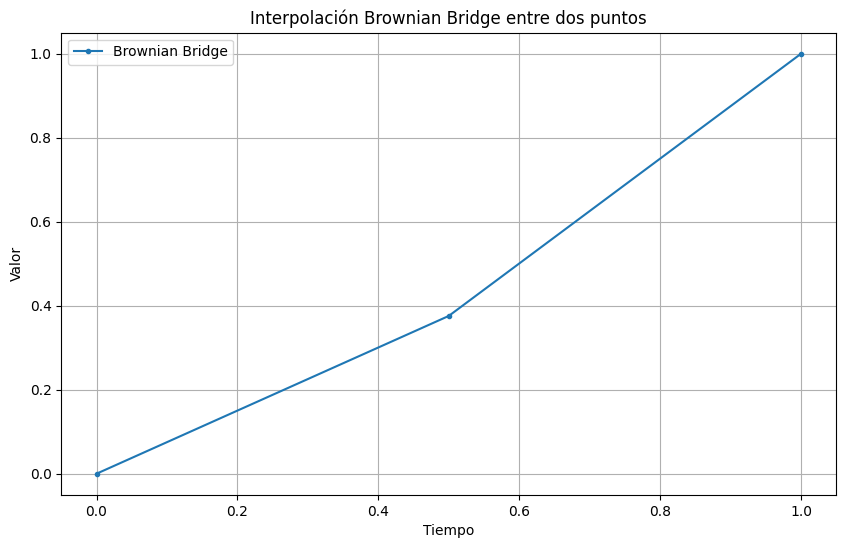

In [4]:
# Parámetros del Brownian Bridge
t0 = 0      # Tiempo inicial
tT = 1      # Tiempo final
x0 = 0      # Valor en t0
xT = 1      # Valor en tT
n_steps = 3  # Número de pasos en la interpolación

# Generar interpolación usando Brownian Bridge
t, X = brownian_bridge(t0, tT, x0, xT, n_steps)
# t, X = interpolador_hermite(np.array([1,5,2,6]), 10)

# Graficar el resultado
plt.figure(figsize=(10, 6))
plt.plot(t, X,".-", label='Brownian Bridge')
# plt.scatter([1,2,3,4,5],np.array([1,3,2,7,5]), color='red', zorder=5, label='Puntos inicial y final')
plt.title('Interpolación Brownian Bridge entre dos puntos')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

In [65]:
import numpy as np
import random
import matplotlib.pyplot as plt

def arm_detector(data, num_ventanas=30, b=0.4):
    n = len(data)
    x = np.arange(n)
    
    # Calcular el tamaño de cada ventana
    window_size = n // num_ventanas

    # Lista para almacenar los porcentajes de puntos dentro de las regiones
    porcentajes = []

    # Ajustar y graficar el ajuste lineal por cada ventana con las líneas paralelas
    for i in range(0, n, window_size):
        end = i + window_size
        if end > n:
            end = n
        
        x_window = x[i:end].reshape(-1, 1)
        y_window = data[i:end]
        
        # Crear y ajustar el modelo de regresión lineal
        modelo = LinearRegression()
        modelo.fit(x_window, y_window)
        
        # Obtener la pendiente y la intersección de la recta ajustada
        pendiente = modelo.coef_[0]
        interseccion = modelo.intercept_
        
        # Predecir valores ajustados
        y_pred = modelo.predict(x_window)
                
        # Calcular las rectas paralelas desplazadas por 'b'
        y_paralela_superior = pendiente * x_window + (interseccion + b)
        y_paralela_inferior = pendiente * x_window + (interseccion - b)
                
        # Calcular el porcentaje de datos dentro de la región delimitada por las líneas paralelas
        dentro_region = np.sum((y_window >= y_paralela_inferior.flatten()) & (y_window <= y_paralela_superior.flatten()))
        fuera_region = len(y_window) - dentro_region
        
        # Calcular el porcentaje de datos dentro de la región respecto a los datos fuera de la región
        porcentaje = (dentro_region * 100)/(dentro_region + fuera_region)
        porcentajes.append(porcentaje)

    def indice_mayor_90(arr):
        n = len(arr)
    
        # Revisar cada índice para encontrar el primero que cumpla la condición
        for i in range(n):
            if np.all(arr[i:] > 90):
                return i
        # Si no hay tal índice, regresar el último índice
        return n - 1
    
    indice = indice_mayor_90(np.array(porcentajes))*window_size
    return indice

def J_univariante(X,tau, corte):
    def distancia(p1, p2):
        return np.linalg.norm(np.array(p2)-np.array(p1))
    x1 = X[tau:]
    y1 = X[:-tau]
    ff1 = np.angle(np.fft.rfft(x1))
    ff2 = np.angle(np.fft.rfft(y1))
    if corte:
        # print(len(ff1),len(ff2))
        transition_point1 = arm_detector(ff1)
        transition_point2 = arm_detector(ff2)
        if transition_point1 != transition_point2:
            transition_point1 = transition_point2 = min(transition_point1, transition_point2)
        ff2 = ff2[:transition_point2]
        ff1 = ff1[:transition_point1]
        # print(len(ff1),len(ff2))
    vectores = []
    for i in range(len(ff1)-1):
        p1 = [ff1[i], ff2[i]]
        p2 = [ff1[i+1], ff2[i+1]]
        cuadrante = [[p2[0]-p1[0], p2[1]-p1[1]], [p2[0]-p1[0], p2[1]+2*np.pi-p1[1]],
            [p2[0]+2*np.pi-p1[0],p2[1]+2*np.pi-p1[1]],[p2[0]+2*np.pi-p1[0],p2[1]-p1[1]],
            [p2[0]+2*np.pi-p1[0],p2[1]-2*np.pi-p1[1]],[p2[0]-p1[0],p2[1]-2*np.pi-p1[1]],
            [p2[0]-2*np.pi-p1[0],p2[1]-2*np.pi-p1[1]],[p2[0]-2*np.pi-p1[0],p2[1]-p1[1]],
            [p2[0]-2*np.pi-p1[0],p2[1]+2*np.pi-p1[1]]]
        distancia1 = [distancia(p1,c) for c in cuadrante]
        p2 = cuadrante[np.argmin(distancia1)]
        vectores.append([p2[0]-p1[0],p2[1]-p1[1]])
    angulos = []
    for i in range(len(vectores)-1):
        v1=vectores[i]
        v2=vectores[i+1]
        if np.linalg.norm(v1) == 0:
            v1_norm = v1
        else:
             v1_norm=v1/np.linalg.norm(v1)
        if np.linalg.norm(v2) == 0:
            v2_norm = v2
        else:
            v2_norm=v2/np.linalg.norm(v2)
        angulo=np.arccos(np.clip(np.dot(v1_norm,v2_norm),-1.0,1.0))
        cruz=v1[0]*v2[1]-v1[1]*v2[0]
        if cruz>0:
            angulo=np.pi-angulo
        if cruz==0 and angulo==0:
            angulo=angulo
        if cruz==0 and angulo<0:
            angulo=np.pi
        if cruz<0:
            angulo=angulo+np.pi
        angulos.append(angulo)
    
    e=[]
    for k in range(len(angulos)):
        e.append(np.exp(angulos[k]*1j))
    e1=np.sum(e)/len(angulos)
    J=1.-np.abs(e1.real)
    return J, angulos

# Aplicación a series de Rössler

In [12]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def rossler_system(t, state, a=0.1, b=0.1, c=3):
    x, y, z = state
    dxdt = -y - z
    dydt = x + a * y
    dzdt = b + z * (x - c)
    return [dxdt, dydt, dzdt]

def generar_uniforme_centrada(n, varianza):
    # Calcular el límite superior e inferior de la distribución uniforme
    limite = np.sqrt(varianza)
    # Generar n números aleatorios con distribución uniforme entre -limite y limite
    return np.random.uniform(-limite, limite, n)

def simulate_rossler_with_noise(duration, dt, snr, initial_state=[1, 1, 1]):
    # Time vector
    t = np.arange(0, duration, dt)
    
    # Solve Rössler system
    sol = solve_ivp(rossler_system, [0, duration], initial_state, t_eval=t, method='RK45')
    x, y, z = sol.y
    
    # Generate white noise
    noise = generar_uniforme_centrada(len(x), 0.00001)
    
    # Add noise to the x-component of the system
    x_noisy = x + noise
    
    return t, x, x_noisy, noise

# Simulate
t, x, x_noisy, noise = simulate_rossler_with_noise(duration, dt, snr)

print('regular', J_univariante(x,1,True))
print('ruido', J_univariante(x_noisy,1,True))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t, x, label='Original Rössler x(t)', linewidth=1.5)
plt.plot(t, x_noisy, label='Noisy Rössler x(t)', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.xlim(0,20)
plt.title(f'Rössler System with SNR = {np.std(x)/np.var(noise)}')
plt.legend()
plt.show()


NameError: name 'duration' is not defined

In [25]:
"""Mapeo Logístico"""
def Logistic_map(x0, r, n):
    orbit_values = []
    x = x0

    def logistic_map(r, x):
        return r * x * (1 - x)

    for _ in range(1000): # Converger
        x = logistic_map(r, x)


    for _ in range(n):
        x = logistic_map(r, x)
        orbit_values.append(x)
    orbit_values = np.array(orbit_values)
    return orbit_values



In [24]:
def tinkerbell_map(x0, y0, a, b, c, d, n_iterations):
    # Inicializar arrays para almacenar las series x e y
    x = np.zeros(n_iterations)
    y = np.zeros(n_iterations)
    
    # Asignar los valores iniciales
    x[0] = x0
    y[0] = y0
    
    # Iterar y aplicar las ecuaciones del mapa de Tinkerbell
    for i in range(1, n_iterations):
        x[i] = x[i-1]**2 - y[i-1]**2 + a * x[i-1] + b * y[i-1]
        y[i] = 2 * x[i-1] * y[i-1] + c * x[i-1] + d * y[i-1]
    
    return x, y

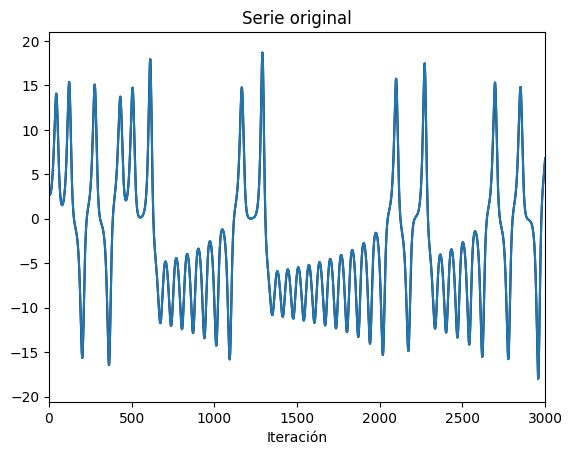

J = 0.16235615001120351
J =  0.9164366018072234


In [15]:
# s_0 = np.loadtxt("x_6.0.txt")
s_0_ruido = s_0 + generar_uniforme_centrada(len(s_0), 0.001)
# s_0 = orbit_values
# s_0 = np.loadtxt("lorenz_x_28.0.txt")

plt.title("Serie original")
plt.plot(s_0,"k")
plt.plot(s_0_ruido)
plt.xlim(0,3000)
plt.xlabel('Iteración')
plt.show()

print("J =",J_univariante(s_0,1, False))
print("J = ", J_univariante(s_0_ruido, 1, False))

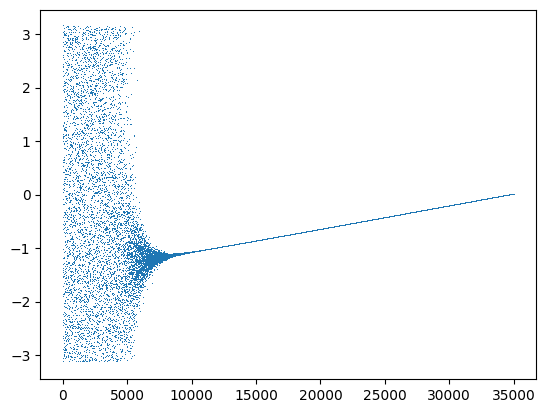

In [16]:
plt.plot(np.angle(np.fft.rfft(s_0)),",")
# plt.xlim(0,2500)
plt.show()

## Discretización de los datos

In [13]:
def discretizar(array, num_partitions):
    if num_partitions == 1:
        print(" Minimo de particiones: 2")
        return np.array([])
    window = (np.abs(np.min(array)) + np.abs(np.max(array)))/(num_partitions - 1)
    discretizador = [np.min(array)+window*(i) for i in range(num_partitions)]
    if discretizador[len(discretizador)-1] != np.max(array):
        discretizador[len(discretizador)-1] = np.max(array)
    array_discreto = []
    for i,valor in enumerate(array):
        array_discreto.append(min(discretizador, key=lambda x: abs(x - valor)))

    return array_discreto

In [12]:
def discretizar_x(array_y, num_partitions):
    if num_partitions == 1:
        print(" Minimo de particiones: 2")
        return np.array([])
    array_x = range(int(len(array_y)))
    window = (len(array_x))/(num_partitions - 1)
    x_discreto = [int(window*(i)) for i in range(num_partitions)]
    array_discreto = []
    for i in x_discreto[0:len(x_discreto)-1]:
        array_discreto.append(array_y[i])
    array_discreto.append(array_y[len(array_x)-1])

    return x_discreto, array_discreto

In [11]:
import numpy as np

def encontrar_extremos_locales(data):
    """
    Encuentra los mínimos y máximos locales de un array de datos.
    
    Parameters:
    data (array): Secuencia de datos cuasi-periódica o n-periódica.
    
    Returns:
    extremos_locales (array): Array que contiene los mínimos y máximos locales.
    """
    # Derivada discreta (diferencias finitas)
    derivada = np.diff(data)
    
    # Buscamos cambios de signo en la derivada (esto indica un máximo o un mínimo)
    maxima = np.where((derivada[:-1] > 0) & (derivada[1:] < 0))[0] + 1
    minima = np.where((derivada[:-1] < 0) & (derivada[1:] > 0))[0] + 1
    
    # Unimos los índices de los máximos y mínimos
    indices_extremos = np.sort(np.concatenate((maxima, minima)))
    if 0 not in indices_extremos:
        indices_extremos = np.insert(indices_extremos, 0, 0)
    
    # Extraemos los valores de los máximos y mínimos locales
    extremos_locales = data[indices_extremos]
    
    return indices_extremos, extremos_locales


## Interpolación de los datos discretos

In [10]:
def interpolador_estocastico(s_0_discreto, n_steps):
    t_list, X_list = [], []
    for i in range(len(s_0_discreto)- 1):
        t0 = i
        tT = i+1
        x0 = s_0_discreto[i]
        xT = s_0_discreto[i+1]
        t, X = brownian_bridge(t0, tT, x0, xT, n_steps)
        t_list = np.concatenate((t_list, t))
        X_list = np.concatenate((X_list, X))
    return X_list

In [9]:
def interpolador_hermite(s_0_discreto, n_steps):
    # Generar los puntos de tiempo correspondientes a los puntos discretos
    t_discreto = np.arange(len(s_0_discreto))

    # Crear un interpolador hermitiano (PCHIP) usando los puntos discretos
    interpolador_pchip = PchipInterpolator(t_discreto, s_0_discreto)

    # Crear una lista de tiempo interpolada con mayor resolución
    t_fina = np.linspace(t_discreto[0], t_discreto[-1], n_steps * (len(s_0_discreto) - 1))

    # Interpolar los valores usando el interpolador PCHIP
    X_fina = interpolador_pchip(t_fina)
    
    # Asegurar que los puntos originales estén en los valores interpolados
    t_fina_con_originales = np.union1d(t_fina, t_discreto)
    X_fina_con_originales = interpolador_pchip(t_fina_con_originales)
    
    return t_fina_con_originales, X_fina_con_originales

In [8]:
def interpolador(subject, method, size):
    # data = np.array([int(line.strip()) for line in subject.to_numpy()])  # Si lo obtienes de un DataFrame
    data = subject
    x = np.arange(len(data))
    
    # Crear 'size' puntos equidistantes
    x_new = np.linspace(0, len(data) - 1, size*(len(data)-1) + len(data))
    
    if method == 'lineal':
        data_interp = np.interp(x_new, x, data)
    elif method == 'herm':
        interpolator = PchipInterpolator(x, data)
        data_interp = interpolator(x_new)
    
    return x_new, data_interp

In [7]:
def add_brownian_between_repeats(data, points_per_segment=2):
    result = []
    n = len(data)
    i = 0
    
    while i < n:
        result.append(data[i])
        # Detectar si hay un segmento repetido
        if i < n - 1 and data[i] == data[i + 1]:
            x0 = data[i]
            xT = data[i + 1]  # Mismo valor, ya que son repetidos
            t0, tT = 0, 1  # Intervalo estándar para el puente browniano
            
            # Generar los puntos interpolados con el puente browniano
            _, bridge = brownian_bridge(t0, tT, x0, xT, points_per_segment + 2)
            # Añadir los puntos generados entre los valores repetidos (excluyendo el primero y último)
            result.extend(bridge[1:-1])
        
        i += 1
    
    return result



In [26]:
def replace_long_repeating_segments(data):
    result = []
    n = len(data)
    i = 0
    
    while i < n:
        start = i
        # Detectar si hay un segmento repetido
        while i < n - 1 and data[i] == data[i + 1]:
            i += 1
        
        segment_length = i - start + 1
        
        if segment_length > 2:  # Si el segmento tiene más de dos puntos repetidos
            result.append(data[start])  # Mantener el primer valor
            x0 = data[start]
            xT = data[i]
            t0, tT = 0, 1  # Intervalo estándar para el puente browniano
            
            # Generar los puntos interpolados con el puente browniano
            _, bridge = brownian_bridge(t0, tT, x0, xT, segment_length)
            result.extend(bridge[1:-1])  # Añadir los puntos generados (sin el primero ni el último)
            result.append(data[i])  # Mantener el último valor
        else:
            # Si hay uno o dos puntos repetidos, se añaden tal como están
            result.extend(data[start:i + 1])
        
        i += 1
    
    return result

# Datos de ejemplo
data = [1.2, 3.5,1.0,1.0,1.0,6.3, 3.1, 6.2, 6.2, 6.2, 6.2, 4.1, 2.0, 2.0, 4.5,5.3,5.3,5.3,5.3,5.3,5.3]
result = replace_long_repeating_segments(data)


In [5]:
def remove_consecutive_duplicates(data):
    if not data:
        return []
    
    result = [data[0]]  # Comenzamos con el primer elemento
    for i in range(1, len(data)):
        if data[i] != data[i - 1]:
            result.append(data[i])
    
    return result


Original: 0.09392997913065793, Discreto: 0.8325727414328007
Sin mecetas:  0.04876149476538605
4480


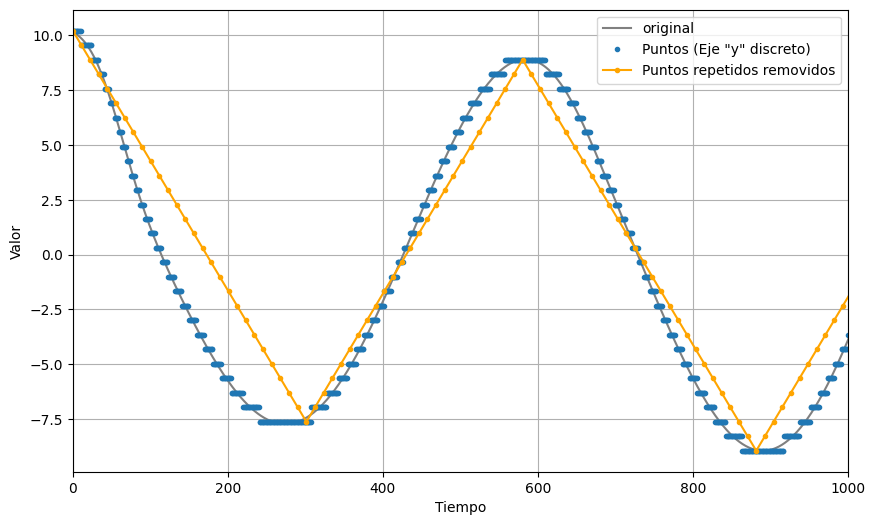

In [42]:
s_0 = np.loadtxt("x_6.0.txt") # Rossler Cota: 1000
# s_0 = [np.sin(5*x) + np.cos(5*x) for x in np.linspace(-25, 25, 15000)] # sin y cos Cota: 1000
# s_0 = [np.sin(x)*np.cos(5*x) for x in np.linspace(-25, 25, 15000)] # Onda modulada Cota: 1000
# s_0 = Logistic_map(0.6, 3.5, 2000) # logistico # Cota 100
# s_0 = np.loadtxt("lorenz_x_28.0.txt") # lorenz # cota 1000
# s_0 = [2*np.arcsin(np.sin(5*x))/np.pi for x in np.linspace(-15,15,15000)] # Funcion de onda triangular # Cota 1000
# x = np.linspace(0, 10000, 10000)
# s_0 = mathieu_cem(1, 10, x)[0] # solución par de orden n=1 Eq Mathieu Cota: 1000


s_0_discreto = discretizar(s_0, 30)

# Graficar el resultado
# s_0_estocastico = add_brownian_between_repeats(s_0_discreto, points_per_segment=1)
# x_0_estocastico, s_0_estocastico = discretizar_x(s_0, 4480)
s_0_estocastico = remove_consecutive_duplicates(s_0_discreto)
# s_0_estocastico = interpolador_estocastico(s_0_estocastico, 2)
# s_0_estocastico = replace_long_repeating_segments(s_0_discreto)


x_original = np.arange(len(s_0))
x_result = np.linspace(0, len(s_0) - 1, len(s_0_estocastico))

print(f'Original: {J_univariante(s_0, 1, True)[0]}, Discreto: {J_univariante(s_0_discreto, 1, True)[0]}')
if len(s_0_estocastico) < 500:
    print('No tamaño suficiente para eliminar mecetas', len(s_0_estocastico))
print(f'Sin mecetas: ',J_univariante(s_0_estocastico, 1, True)[0])
print(len(s_0_estocastico))

plt.figure(figsize=(10, 6))
# plt.plot(t_estocastico, X_estocastico,'.', color = 'orange', label = 'Interpolacion Estocástica')
# plt.plot(norm(t_herm)*np.max(x_discreto), X_herm,'.-' ,color = 'red', alpha = 0.6, label = 'Interpolacion Hermitiana')
plt.plot(s_0,'-' ,color='gray', label = 'original')
# plt.plot(t_herm, X_herm,'.', color = 'red',alpha=0.6, label = 'Interpolacion Hermite')
plt.plot(s_0_discreto,".", label='Puntos (Eje "y" discreto)')
plt.plot(x_result, s_0_estocastico, '.-', color = 'orange', label = 'Puntos repetidos removidos')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.xlim(0,1000)
plt.legend()
plt.grid(True)
plt.show()

# print(f'Hermitiano: {J_univariante(X_herm,1, True)}, Estocástico: {J_univariante(X_estocastico,1, True)}, Discreto: {J_univariante(s_0_discreto,1,True)}, OG: {J_univariante(s_0,1,True)}')

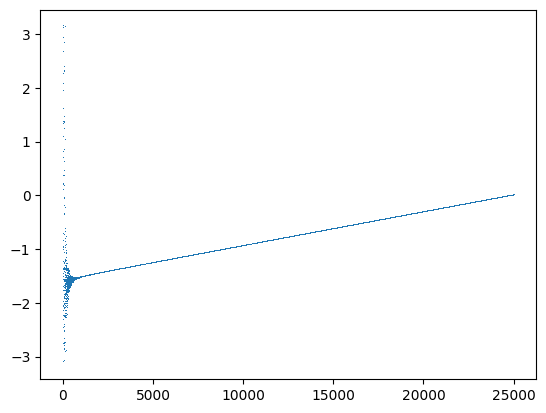

In [246]:
plt.plot(np.angle(np.fft.rfft(s_0)),",")
# plt.xlim(0,2500)
plt.show()